<div>
<img src="images/QDC_Notebook_Header_Day-01.png"/>
</div>


# QDC Day 1 - Challenge Track B: Utility-scale workload with sample-based quantum diagonalization (SQD)
The functions catalog contains abstracted services that handle multiple stages of a quantum workflow. In this track, we'll explore Qiskit addons: a collection of modular research capabilities for enabling algorithm discovery at the utility scale. Qiskit addons address particular tasks within a stage of a larger quantum workflow (like Qiskit patterns) to scale or design new algorithms. These tools set the stage to enable users to release functions and workflows of their own in the quantum applications ecosystem.

One such addon is [**Sample-Based Quantum Diagonalization (SQD)**](https://docs.quantum.ibm.com/guides/qiskit-addons-sqd) -- a technique for finding eigenvalues and eigenvectors of quantum operators, such as a quantum system Hamiltonian, using quantum and distributed classical computing together. Classical distributed computing is used to process samples obtained from a quantum processor, and to project and diagonalize a target Hamiltonian in a subspace spanned by them. This allows SQD to be robust to samples corrupted by quantum noise and deal with large Hamiltonians, such as chemistry Hamiltonians with millions of interaction terms, beyond the reach of any exact diagonalization methods.

In this track, you'll dive into SQD to simulate Hamiltonians by processing approximate eigenstates from quantum circuits and refining them with classical solvers. Through this exercise, you’ll adjust key parameters to improve robustness against quantum noise, experience how Qiskit addons enhance utility-scale quantum workloads, and get hands-on with tools that set the stage for designing and releasing custom workflows in the growing quantum applications ecosystem.

# Table of Contents

**Track B**
* [**Deep Dive into SQD: Energy estimation of a Fermionic Hamiltonian with sample-based quantum diagonalization**](#link-to-track-b-notebook)
    * [Part 1: Tutorial - Learn how to use the `qiskit-addon-sqd` api to approximate a molecule's ground state](#Part-1:-Tutorial)
    * [Part 2: Challenge - Modify the size of the subspace in which the operator is projected and diagonalized to improve ground state estimation](#Part-2:-Challenge---Refining-the-Ground-State-Energy-Estimation)

**For access to the Track A notebook, please click [here](link).**

In [5]:
# Imports
from qc_grader.challenges.qdc_2024 import grade_day1b_ex1, submit_feedback_1b_1, submit_feedback_1b_2, submit_name

In [2]:
# Required packages
# %pip install qiskit
# %pip install qiskit-aer
# %pip install qiskit-ibm-runtime
# %pip install qiskit-ibm-transpiler
# %pip install qiskit-ibm-catalog
# %pip install qiskit-addon-utils
# %pip install qiskit-serverless
# %pip install qiskit-addon-sqd
# %pip install qiskit-addon-obp
# %pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git

## Overview
The **Sample-Based Quantum Diagonalization (SQD)** method is designed to overcome limitations of exact diagonalization methods, making it suitable for handling large Hamiltonians with millions of interaction terms, such as those found in quantum chemistry. Using a sample-based approach, SQD projects and diagonalizes target Hamiltonians in a subspace formed by samples obtained from quantum circuits. These circuits are typically tailored to represent probable eigenstates of the target operator, enabling robust calculations even in the presence of quantum noise.

This notebook guides you through the SQD Qiskit addon; you'll learn how the SQD method works and explore its application to a Fermionic Hamiltonian. The notebook is structured as follows:

- **Part 1: Tutorial**  
    In Part 1, you will learn how to use a Qiskit addon to set up and execute the SQD method for a Hamiltonian describing the $N_2$ molecule in a given basis. This section will provide you with hands-on experience with Qiskit addons, focusing on **energy estimation** using quantum samples combined with classical solvers.

- **Part 2: Challenge**  
    Once you've completed the tutorial, you'll move on to the challenge section. Here, you will be tasked with tuning parameters to improve the performance of SQD and achieve a closer approximation of the molecule's ground state energy. **Your goal** is to refine the parameters to enhance accuracy while considering noise and other quantum device constraints.


## Getting Started
To begin, ensure you have installed the required Qiskit addon packages for this notebook. We recommend using pip to install the `qiskit-addon-sqd` package, which includes essential tools for the Sample-Based Quantum Diagonalization (SQD) method. 


In [3]:
# %pip install 'qiskit-addon-sqd'

For more installation information, refer to the [installation instructions](https://qiskit.github.io/qiskit-addon-sqd/install.html) in the documentation. Now that your environment is ready, let's get started! 

# Part 1: Tutorial - Energy Estimation of a Fermionic Hamiltonian with Sample-Based Quantum Diagonalization

In this tutorial we will implement a [Qiskit pattern](https://docs.quantum.ibm.com/guides/intro-to-patterns) showing how to post-process noisy quantum samples to find an approximation to the ground state of the $N_2$ molecule at equilibrium in the ``6-31G basis set``. We will follow a sample-based quantum diagonalization approach [[1]](https://arxiv.org/abs/2405.05068) to process samples taken from a ``36``-qubit quantum circuit (32 spin qubits + 4 auxiliary qubits). In order to account for the effect of quantum noise, the [self-configuration recovery technique is used](https://arxiv.org/abs/2405.05068).

The pattern can be described in four steps:

1. **Map to quantum problem**
    - Generate an ansatz for estimating the ground state
2. **Optimize the problem**
    - Transpile the ansatz for the backend
3. **Execute experiments**
    - Draw samples from the ansatz using the ``Sampler`` primitive
4. **Post-process results**
   - Self-consistent configuration recovery loop
       - Post-process the full set of bitstring samples, using prior knowledge of particle number and the average orbital occupancy calculated on the most recent iteration.
       - Probabilistically create batches of subsamples from recovered bitstrings.
       - Project and diagonalize the molecular Hamiltonian over each sampled subspace.
       - Save the minimum ground state energy found across all batches and update the average orbital occupancy.


For this example, the interacting-electron Hamiltonian takes the generic form:

$$
\hat{H} = \sum_{ \substack{pr\\\sigma} } h_{pr} \, \hat{a}^\dagger_{p\sigma} \hat{a}_{r\sigma}
+ 
\sum_{ \substack{prqs\\\sigma\tau} }
\frac{(pr|qs)}{2} \, 
\hat{a}^\dagger_{p\sigma}
\hat{a}^\dagger_{q\tau}
\hat{a}_{s\tau}
\hat{a}_{r\sigma}
$$

$\hat{a}^\dagger_{p\sigma}$/$\hat{a}_{p\sigma}$ are the fermionic creation/annihilation operators associated to the $p$-th basis set element and the spin $\sigma$. $h_{pr}$ and $(pr|qs)$ are the one- and two-body electronic integrals. These are loaded from an ``fcidump`` file with standard chemistry software.

The SQD workflow with self-consistent configuration recovery is depicted in the following diagram.

![SQD diagram](images/sqd_diagram.png)

SQD is known to work well when the target eigenstate is sparse: the wave function is supported in a set of basis states $\mathcal{S} = \{|x\rangle \}$ whose size increases polynomially with the size of the problem. In this scenario, the diagonalization of the Hamiltonian projected into the subspace defined by $\mathcal{S}$:
$$
H_\mathcal{S} = P_\mathcal{S} H  P_\mathcal{S} \textrm{ with } P_\mathcal{S} = \sum_{x \in \mathcal{S}} |x \rangle \langle x |;
$$
yields a good approximation to the target eigenstate. The role of the quantum device is to produce samples of the members of $\mathcal{S}$ only. First, a quantum circuit prepares the state $|\Psi\rangle$ in the quantum device. The Jordan-Wigner encoding is used. Consequently, members of the computational basis represent Fock states (electronic configurations/determinants). The circuit is sampled in the computational basis, yielding the set of noisy configurations $\tilde{\mathcal{X}}$. The configurations are represented by bitstrings. The set $\tilde{\mathcal{X}}$ is then passed into the classical post-processing block, where the [self-consistent configuration recovery technique](https://arxiv.org/abs/2405.05068) is used. In the SQD framework, the role of the quantum device is to produce a probability distribution.

### Map problem to a quantum circuit

In this tutorial, we will approximate the ground state energy of an $N_2$ molecule. First, we will specify the molecule and its properties. Next, we will create a [local unitary cluster Jastrow (LUCJ)](https://pubs.rsc.org/en/content/articlelanding/2023/sc/d3sc02516k) ansatz (quantum circuit) to generate samples from a quantum computer for ground state energy estimation.

First, we will specify the molecule and its properties.

<div class="alert alert-block alert-info">
    
⚠️ **Note:** The circuit data is precomputed and provided in this notebook, so `pyscf` installation is not required. You may skip the cell below and proceed directly to the **"Loading the Optimized Ansatz"** section.
</div>


In [4]:
import warnings, pickle
import numpy as np

# warnings.filterwarnings("ignore")

# # from pyscf import ao2mo, tools

# Specify molecule properties
num_orbitals = 16
num_elec_a = num_elec_b = 5
open_shell = False
spin_sq = 0

# # Read in molecule from disk if using pyscf
# # mf_as = tools.fcidump.to_scf("utils/n2_fci.txt")
# # hcore = mf_as.get_hcore()
# # eri = ao2mo.restore(1, mf_as._eri, num_orbitals)
# # nuclear_repulsion_energy = mf_as.mol.energy_nuc()

# # Load values if not using pyscf
hcore = np.load("utils/hcore.npy")
eri = np.load("utils/eri.npy")
with open("utils/nuclear_repulsion_energy.pkl", "rb") as f:
    nuclear_repulsion_energy = pickle.load(f)

Next, we will create the ansatz. The ``LUCJ`` ansatz is a parameterized quantum circuit, and we will initialize it with `t2` and `t1` amplitudes obtained from a CCSD calculation.

In [5]:
# from pyscf import cc

# mf_as.kernel()
# mc = cc.CCSD(mf_as)
# mc.kernel()
# t1 = mc.t1
# t2 = mc.t2

## Loading the optimized ansatz

In this tutorial, we’ll begin with a pre-prepared and **optimized ansatz file**. The pre-prepared ansatz has been created with IBM's heavy-hex topology in mind, adopting a **zig-zag pattern** for qubit interactions. In this pattern, orbitals of the same spin are connected in a zig-zag line across the heavy-hex lattice (shown below).

![lucj_ansatz](images/lucj_ansatz_zig_zag_pattern.jpg)

The optimized ansatz file has the circuit configured with `t1` and `t2` amplitudes for our molecule’s closed-shell Hartree-Fock state. By starting with an already optimized circuit, we can focus directly on the quantum diagonalization tasks. For more details on how this is implemented, check out the tutorial in the docs [here](https://learning.quantum.ibm.com/tutorial/improving-energy-estimation-of-a-fermionic-hamiltonian-with-sqd).



In [6]:
from qiskit import qpy

with open("utils/N2_UCJ_Transpiled.qpy", "rb") as fd:
    isa_circuit = qpy.load(fd)[0]

### Execute experiments

After optimizing the circuit for hardware execution, we are ready to run it on the target hardware and collect samples for ground state energy estimation.

<div class="alert alert-block alert-warning">
    
⚠️ **Note:** We have commented out the code for running the circuit on a QPU and left it for the user's reference. Instead of running on real hardware in this walkthrough, we will just read in 100k samples drawn from ``ibm_sherbrooke`` at an earlier time.

</div>


In [7]:
import numpy as np

# from qiskit_ibm_runtime import SamplerV2 as Sampler

# sampler = Sampler(mode=backend)
# job = sampler.run([isa_circuit], shots=100_000)
# primitive_result = job.result()
# pub_result = primitive_result[0]
# counts = pub_result.data.meas.get_counts()

counts = np.load("utils/N2_device_counts.npy", allow_pickle=True).item()

### Post-process results using SQD

In this section, we’ll post-process the quantum samples generated from the optimized ansatz to estimate the molecule’s ground state energy. This step involves transforming our data, iteratively refining it, and applying self-consistent configuration recovery to improve accuracy.

### Step 1: Convert Counts to Bitstring and Probability Arrays

We start by converting the raw counts from our quantum device into a **bitstring matrix** and a **probability array**. Each row in the bitstring matrix represents a unique quantum state (bitstring) sampled from our circuit. Since qubits are indexed from the right of a bitstring in Qiskit, column ``0`` represents qubit ``N-1``, and column ``N-1`` represents qubit ``0``, where ``N`` is the number of qubits.

The probability array reflects the likelihood of each bitstring occurring in the sampled data. Following the ordering from the LUCJ ansatz, the alpha particles are represented in the column index range ``(N, N/2]``, and the beta particles are represented in the column range ``(N/2, 0]``.

In [8]:
from qiskit_addon_sqd.counts import counts_to_arrays

# Convert counts into bitstring and probability arrays
bitstring_matrix_full, probs_arr_full = counts_to_arrays(counts)

In [9]:
print(bitstring_matrix_full, "\n", "\n", probs_arr_full)

[[False False False ...  True False  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True False  True]
 [ True  True  True ...  True False False]] 
 
 [9.99927237e-06 9.99927291e-06 9.99929083e-06 ... 9.99934578e-06
 9.99936349e-06 9.99934828e-06]


Iteratively refine the samples using configuration recovery and approximate the ground state at each iteration

There are a few user-controlled options which are important for this technique:

- ``iterations``: Number of self-consistent configuration recovery iterations
- ``n_batches``: Number of batches of configurations used by the different calls to the eigenstate solver
- ``samples_per_batch``: Number of unique configurations to include in each batch
- ``max_davidson_cycles``: Maximum number of Davidson cycles run by each eigensolver

In [10]:
# SQD options
iterations = 5
rand_seed = 42

# Eigenstate solver options
n_batches = 5
samples_per_batch = 50
max_davidson_cycles = 200

Additionally, we must initialize a couple of data structures that will be used throughout the course of the SQD algorithm.

- ``energy_hist``: The history of ground state energies obtained for the individual batches at each iteration of the algorithm
- ``occupancy_hist``: The occupancy of each spin orbital averaged over all batches at each iteration of the algorithm
- ``occupancies_bitwise``: An array containing the average orbital occupancies, such that element ``i`` corresponds to the same orbital as the ``i``'th bit in the samples. When this is `None`, it signifies we are on iteration ``0`` and have no occupancy information yet. In that case, we simply discard all non-physical samples (samples with incorrect hamming weight).

In [11]:
energy_hist = np.zeros((iterations, n_batches))  # energy history
occupancy_hist = np.zeros((iterations, 2 * num_orbitals))
occupancies_bitwise = None  # orbital i corresponds to column i in bitstring matrix

**Bootstrapping SQD**

Iteration ``0`` of SQD is a special case, so we will use it to explain each step in the algorithm before proceeding to the configuration recovery loop.

1. Refine **all** raw samples from QPU
2. Subsampling
3. Subspace diagonalization
4. Update tracked quantities

**1. Refine all raw samples from QPU**

Since we have not yet done any subspace diagonalization, we do not have any information about the average orbital occupancy from those solutions. Therefore, we cannot do configuration recovery during iteration ``0``.

Instead, we simply remove all non-physical samples (samples with incorrect hamming weight in either the alpha or beta systems) and diagonalize in subspaces formed by the remaining configurations. This will be done during the next step.
<div class="alert alert-block alert-info">
    
⚠️ **Note**: If the QPU does not produce enough samples which support the ground state, the SQD algorithm will not be able to bootstrap. The technique requires the ansatz be a good description of the ground state and for samples from that ansatz to contain adequate support of the ground state.

</div>


In [12]:
bitstring_matrix_tmp = bitstring_matrix_full
probs_arr_tmp = probs_arr_full

**2. Subsampling**

In the second step of SQD, we must generate the batches of samples. We previously set ``bitstring_matrix_tmp`` and ``probs_array_tmp`` to include **all** the raw samples from the QPU. Normally, the batches of subsamples would be sampled from a refined set of bitstrings, but for iteration ``0`` the batches will be selected from the raw QPU samples which reflect correct particle number in both the alpha and beta subsystems.

In [13]:
from qiskit_addon_sqd.subsampling import postselect_and_subsample

batches = postselect_and_subsample(
    bitstring_matrix_tmp,
    probs_arr_tmp,
    hamming_right=num_elec_a,
    hamming_left=num_elec_b,
    samples_per_batch=samples_per_batch,
    num_batches=n_batches,
    rand_seed=rand_seed,
)

Now that we have batches of subsamples, we must project and diagonalize the Hamiltonian in each of the subspaces spanned by those subsamples. This is, computationally, most demanding part of the algorithm, and it will likely be necessary to parallelize these solvers for utility-scale problems. Since the problem in this example is relatively small, we will just run the solvers in a loop.

In [14]:
from qiskit_addon_sqd.fermion import solve_fermion

# Run eigenstate solvers in a loop. This loop should be parallelized for larger problems.
energies = np.zeros(n_batches)
occupancies = np.zeros((n_batches, 2 * num_orbitals))
for j in range(n_batches):
    energy_sci, _, avg_occs, _ = solve_fermion(
        batches[j],
        hcore,
        eri,
        open_shell=open_shell,
        spin_sq=spin_sq,
        max_davidson=max_davidson_cycles,
    )
    energy_sci += nuclear_repulsion_energy
    energies[j] = energy_sci
    occupancies[j, :num_orbitals] = avg_occs[0]
    occupancies[j, num_orbitals:] = avg_occs[1]

**Update the tracked quantities**

We have now reached the end of the first iteration of the SQD algorithm, and all that is left to do is to append our tracked quantities to the history and begin the next iteration.

Here it is important to note that we can combine the average occupancies from across all batches to further refine their averages. In contrast, for the energy values we will only be interested in the minimal energy value obtained across the all the batches.

In [15]:
from qiskit_addon_sqd.fermion import flip_orbital_occupancies

# Combine batch results
avg_occupancies = np.mean(occupancies, axis=0)
# The occupancies from the solver should be flipped to match the bits in the bitstring matrix.
occupancies_bitwise = flip_orbital_occupancies(avg_occupancies)

# Track optimization history
energy_hist[0, :] = energies
occupancy_hist[0, :] = avg_occupancies

**Continuing configuration recovery**

After having completed the first iteration of the SQD algorithm step-by-step, we are now ready to run the remaining iterations in a loop.

In the following code cell, you see all of the previous steps combined into one big loop, with one major difference: we now have gathered the average occupancy information (``avg_occupancies``) which we can use to perform configuration recovery at the beginning of the loop.

In [63]:
from qiskit_addon_sqd.configuration_recovery import recover_configurations

for i in range(1, iterations):
    print(f"Starting configuration recovery iteration {i}")
    bs_mat_tmp, probs_arr_tmp = recover_configurations(
        bitstring_matrix_full,
        probs_arr_full,
        occupancies_bitwise,
        num_elec_a,
        num_elec_b,
        rand_seed=rand_seed,
    )

    # Create batches, and throw out configurations with incorrect particle
    # number in either the spin-up or spin-down systems
    batches = postselect_and_subsample(
        bs_mat_tmp,
        probs_arr_tmp,
        hamming_right=num_elec_a,
        hamming_left=num_elec_b,
        samples_per_batch=samples_per_batch,
        num_batches=n_batches,
        rand_seed=rand_seed,
    )

    # Run eigenstate solvers in a loop. This loop should be parallelized for larger problems.
    energies = np.zeros(n_batches)
    occupancies = np.zeros((n_batches, 2 * num_orbitals))
    for j in range(n_batches):
        energy_sci, coeffs_sci, avg_occs, _ = solve_fermion(
            batches[j],
            hcore,
            eri,
            open_shell=open_shell,
            spin_sq=spin_sq,
            max_davidson=max_davidson_cycles,
        )
        energy_sci += nuclear_repulsion_energy
        energies[j] = energy_sci
        occupancies[j, :num_orbitals] = avg_occs[0]
        occupancies[j, num_orbitals:] = avg_occs[1]

    # Combine batch results
    avg_occupancies = np.mean(occupancies, axis=0)
    # The occupancies from the solver should be flipped to match the bits in the bitstring matrix.
    occupancies_bitwise = flip_orbital_occupancies(avg_occupancies)

    # Track optimization history
    energy_hist[i, :] = energies
    occupancy_hist[i, :] = avg_occupancies

Starting configuration recovery iteration 1
Starting configuration recovery iteration 2
Starting configuration recovery iteration 3
Starting configuration recovery iteration 4


### Visualize the results

The first plot shows how far our approximations are from chemical accuracy (typically accepted to be ``1 kcal/mol`` $\approx$ ``1.6 mH``).

The second plot shows the average occupancy of each spatial orbital after the final iteration. We can see that both the spin-up and spin-down electrons occupy the first five orbitals with high probability in our solutions.

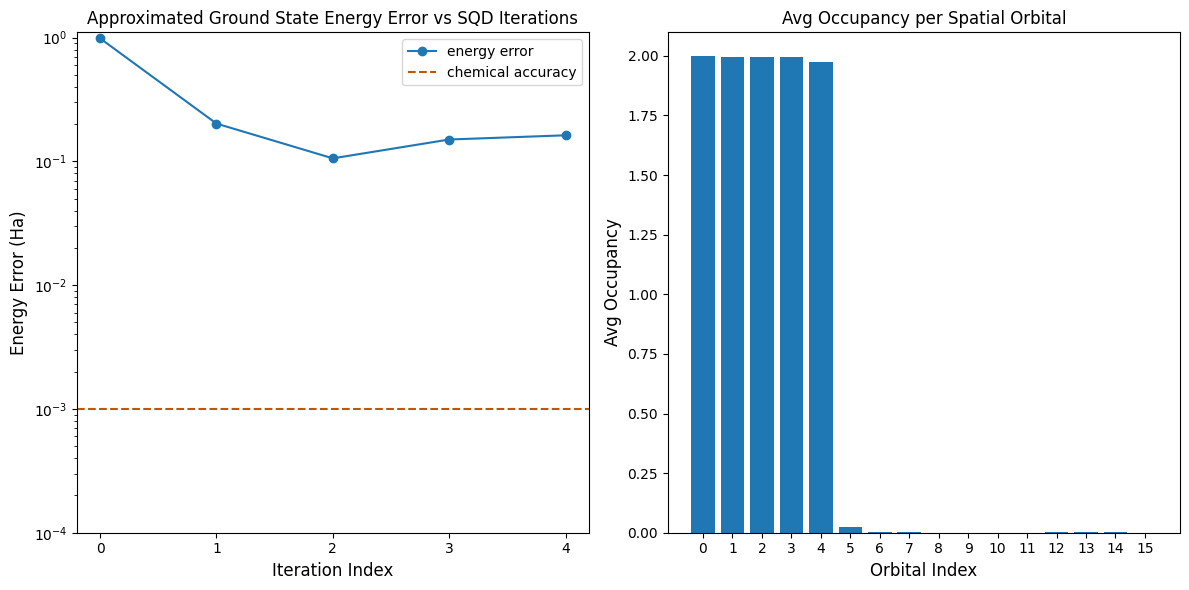

In [64]:
import matplotlib.pyplot as plt

# Data for energies plot
n2_exact = -109.10288938
x1 = range(iterations)
e_diff = [abs(np.min(energies) - n2_exact) for energies in energy_hist]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = avg_occupancies[:num_orbitals] + avg_occupancies[num_orbitals:]
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## Part 2: Challenge - Refining the Ground State Energy Estimation

Congratulations on completing Part 1! You now have hands-on experience with Sample-Based Quantum Diagonalization (SQD) and have used a quantum circuit to approximate the ground state energy of a molecule.

In **Part 2**, you’ll take on a challenge to improve the accuracy of the energy estimation. While our initial setup in Part 1 provided a baseline approximation, here, you’ll explore how different parameter choices impact performance.



<div class="alert alert-block alert-warning">

🏆 **Scored Challenge** 

This is a scored challenge, and your submission results will count toward the leaderboard!

Good luck, take your time to experiment and enjoy the challenge!
</div>


<a id="exercise_1"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 1: Refining the Ground State Energy Estimation</b> 

In the tutorial example, we used small subspaces and limited the number of batches to 5 per iteration to get an initial approximation of the molecule's ground state energy. However, there’s significant room for improvement in accuracy. Your task in **Part 2** is to enhance the energy estimation by experimenting with two key parameters:

- **Subspace Size** (`samples_per_batch`): Adjust the number of samples per batch to define the subspace size used for Hamiltonian projection and diagonalization. Increasing this value can improve accuracy but may increase computational load.
- **Number of Batches** (`num_batches`): Change the number of batches to find a balance between computational efficiency and result precision at each iteration.

Using these parameters strategically, aim to bring the estimated ground state energy as close as possible to the true value. Test different combinations to minimize the error, taking into account the effect of noise and hardware constraints.

Good luck, and let’s see how close you can get to the true ground state energy!

</div>

---

### Participants should submit

- (int) `n_batches`: The number of subspaces in which to project and diagonalize the Hamiltonian at each of the 5 iterations.
- (int) `samples_per_batch`: The number of samples to use to generate the subspaces.




<div class="alert alert-block alert-info"> 
    
⚠️ **Please Note:**
This notebook is structured so that **Part 2: Challenge** can be run independently of **Part 1: Tutorial**. If you’d like, you can skip directly to this section and adjust the parameters without needing to re-run the entire notebook.
</div>


First, we will define a function which performs the same loop as shown above and takes in the ``num_batches`` and ``samples_per_batch`` arguments as inputs.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import tools, ao2mo

from qiskit_addon_sqd.counts import counts_to_arrays, generate_counts_uniform
from qiskit_addon_sqd.subsampling import postselect_and_subsample
from qiskit_addon_sqd.fermion import solve_fermion, flip_orbital_occupancies
from qiskit_addon_sqd.configuration_recovery import recover_configurations


def sqd_configuration_recovery(n_batches: int, samples_per_batch: int) -> float:
    """Perform SQD on N2 molecule, given some subspace parameters."""
    iterations = 5
    num_orbitals = 16
    num_elec_a = num_elec_b = 5
    rand_seed = int(np.random.default_rng(2**24).random())

    counts = np.load("utils/N2_device_counts.npy", allow_pickle=True).item()
    # Convert counts into bitstring and probability arrays
    bitstring_matrix, probabilities = counts_to_arrays(counts)

    # Read in molecule from disk if using pyscf
    # mf_as = tools.fcidump.to_scf("utils/n2_fci.txt")
    # hcore = mf_as.get_hcore()
    # eri = ao2mo.restore(1, mf_as._eri, num_orbitals)
    # nuclear_repulsion_energy = mf_as.mol.energy_nuc()

    # Load values if not using pyscf
    hcore = np.load("utils/hcore.npy")
    eri = np.load("utils/eri.npy")
    with open("utils/nuclear_repulsion_energy.pkl", "rb") as f:
        nre = pickle.load(f)

    # Self-consistent configuration recovery loop
    energy_hist = np.zeros((iterations, n_batches))  # energy history
    occupancy_hist = np.zeros((iterations, 2 * num_orbitals))
    occupancies_bitwise = None  # orbital i corresponds to column i in bitstring matrix
    for i in range(iterations):
        print(f"Starting configuration recovery iteration {i}")
        # On the first iteration, we have no orbital occupancy information from the
        # solver, so we just post-select from the full bitstring set based on hamming weight.
        if occupancies_bitwise is None:
            bs_mat_tmp = bitstring_matrix
            probs_arr_tmp = probabilities

        # If we have average orbital occupancy information, we use it to refine the full set of noisy configurations
        else:
            bs_mat_tmp, probs_arr_tmp = recover_configurations(
                bitstring_matrix,
                probabilities,
                occupancies_bitwise,
                num_elec_a,
                num_elec_b,
                rand_seed=rand_seed,
            )

        # Throw out configurations with incorrect particle number in either the spin-up or spin-down systems
        batches = postselect_and_subsample(
            bs_mat_tmp,
            probs_arr_tmp,
            hamming_right=num_elec_a,
            hamming_left=num_elec_b,
            samples_per_batch=samples_per_batch,
            num_batches=n_batches,
            rand_seed=rand_seed,
        )

        # Run eigenstate solvers in a loop. This loop should be parallelized for larger problems.
        energy_tmp = np.zeros(n_batches)
        occs_tmp = np.zeros((n_batches, 2 * num_orbitals))
        for j in range(n_batches):
            energy_sci, _, avg_occs, _ = solve_fermion(
                batches[j],
                hcore,
                eri,
            )
            energy_sci += nre
            energy_tmp[j] = energy_sci
            occs_tmp[j, :num_orbitals] = avg_occs[0]
            occs_tmp[j, num_orbitals:] = avg_occs[1]

        # Combine batch results
        avg_occupancies = np.mean(occs_tmp, axis=0)
        # The occupancies from the solver should be flipped to match the bits in the bitstring matrix.
        occupancies_bitwise = flip_orbital_occupancies(avg_occupancies)

        # Track optimization history
        energy_hist[i, :] = energy_tmp
        occupancy_hist[i, :] = avg_occupancies

    return energy_hist


def visualize_sqd_results(energy_hist):
    # Hard code some values
    n2_exact = -109.10288938
    iterations = 5
    num_orbitals = 16

    x1 = range(iterations)
    e_diff = [abs(np.min(energies) - n2_exact) for energies in energy_hist]
    yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

    # Chemical accuracy (+/- 1 milli-Hartree)
    chem_accuracy = 0.001

    fig, axs = plt.subplots(1, 1, figsize=(6, 6))

    # Plot energies
    axs.plot(x1, e_diff, label="energy error", marker="o")
    axs.set_xticks(x1)
    axs.set_xticklabels(x1)
    axs.set_yticks(yt1)
    axs.set_yticklabels(yt1)
    axs.set_yscale("log")
    axs.set_ylim(1e-4)
    axs.axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
    axs.set_title("Approximated Ground State Energy Error vs SQD Iterations")
    axs.set_xlabel("Iteration Index", fontdict={"fontsize": 12})
    axs.set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
    axs.legend()

    plt.tight_layout()
    return plt


In [3]:
### Write your code below here ###

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    instance="events/qdc-participant2/user-101",
    token="1a60533a1a3f011b9de0f55cd8ce72e3736b949fa4c78431b85ccfe43106a90e99ba9c40809f1efb8d3d8983ce8779ad768640004fa7712e1964c72f07fb147d",
    overwrite=True,
)

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='events/qdc-participant2/user-101', token='1a60533a1a3f011b9de0f55cd8ce72e3736b949fa4c78431b85ccfe43106a90e99ba9c40809f1efb8d3d8983ce8779ad768640004fa7712e1964c72f07fb147d')

num_batches = 1
samples_per_batch = 100001

### Don't change any code past this line ###

In [ ]:
num_orbitals = 16

counts = np.load("utils/N2_device_counts.npy", allow_pickle=True).item()
# Convert counts into bitstring and probability arrays
bitstring_matrix_full, probs_arr_full = counts_to_arrays(counts)

energy_hist = sqd_configuration_recovery(num_batches, samples_per_batch)
min_e = np.min(energy_hist)  # Submit this value
print(
    "###########################################################################\n"
    f"Ground state energy approximation: {min_e}\n"
    "###########################################################################"
)
print(1 / (min_e + 109.10288938))
plt = visualize_sqd_results(energy_hist)
plt.show()

In [6]:
# Please choose your username for the leaderboard

username = "GuillermoAbadLopez"
submit_name(username)

Submitting your answer. Please wait...
Username submitted.


In [ ]:
from qc_grader.challenges.qdc_2024 import grade_day1b_ex1

num_batches = 1
samples_per_batch = 100000

grade_day1b_ex1(num_batches, samples_per_batch)
# Expected result type: Int, Int

<a id="scoring_func"></a>
<div class="alert alert-block alert-success">
    
⚠️ **About the scoring function** 

Your score in this challenge depends on how close your calculated energy value is to the exact ground state energy for the molecule.

The exact ground state energy is `-109.10288938`. If your answer falls below this value, it’s considered physically impossible, energy cannot be lower than the true ground state. In this case, you’ll need to adjust your parameters and try again.

For valid results (above the ground state energy), your score is calculated as follows:

$$\text{Score} = \frac{1}{\text{Answer} - \text{Exact Ground State}}$$

A smaller energy error results in a higher score, so aim to get as close as possible to the exact ground state energy for a better score.

</div>


<div class="alert alert-block alert-info">

💬 **Feedback:** Please provide feedback on the level of abstraction provided by Qiskit addons. Is it the right amount of abstraction? Do you wish there were more or less parameters available for you to adjust? Why? (Please expand)
</div>

In [ ]:
# Submit your feedback here

# feedback =
# submit_feedback_1b_1(feedback)
# Expected result type: String

<div class="alert alert-block alert-success">
<b>Make the most of the in-person QDC experience</b>
    
Feel free to experiment with the addons to discover the different ways they can add value to your quantum projects. Please do not hesitate to reach out to the mentors and IBMers in the room to ask questions and learn how to unlock even more potential from each of these addons!

</div>

<div class="alert alert-block alert-info">

💬 **Feedback:** How do you envision using Qiskit addons in your work after the Challenge?

</div>

In [ ]:
# Submit your feedback here

# feedback =
# submit_feedback_1b_2(feedback)
# Expected result type: String

## Congratulations on completing the Day 1 Challenge!

You’ve completed Day 1 of the challenge and have reached the end of this notebook, where you explored the Sample-Based Quantum Diagonalization (SQD) Qiskit addon and tackled the challenge of refining ground state energy estimations for a molecular Hamiltonian! 

Feel free to refer back to this notebook, check out the other track, revisit exercises or try some of the optional sections to refine your skills. We hope this journey has inspired you to push the boundaries of quantum computing!

Get ready for Day 2, where we’ll dive into new concepts and tackle even more exciting quantum challenges. We look forward to seeing you continue your quantum journey!

**Happy coding, and see you on Day 2 for more quantum challenges!**

# Additional information

**Created by:** Alejandra Perea Rojas, Bryce Fuller, Caleb Johnson, Javier Robledo Moreno, Jennifer Glick, Jim Garrison, Sanket Panda, Junye Huang, Max Rossmannek, Vishal Sharathchandra Bajpe

**Advised by:** Abby Mitchell, Blake Johnson, Henry Zou, Tushar Mittal, Vincent Pascuzzi

**Version:** 1.1.0